# **Practico Mentoria - Aprendizaje Supervisado**
---

Se propone la elaboración de un informe o presentación, en formato estatico:
* PDF
* Markdowns
* Google Docs

Que responda a las cuestiones solicitadas en cada seccion de esta **Jupyter Notebook**.

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.  
Por lo cual debe estar redactado de forma consisa y comprensible.

## **Referencias**

* https://relopezbriega.github.io/blog/2016/09/26/series-de-tiempo-con-python/
* https://www.analyticslane.com/2018/08/15/manipulacion-series-temporales-con-pandas/
* http://www.escuela-verano.otrasenda.org/wp-content/uploads/2015/06/curso_series.pdf
* https://medium.com/datos-y-ciencia/modelos-de-series-de-tiempo-en-python-f861a25b9677

In [1]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.0)


In [2]:
import statsmodels
print(statsmodels.__version__) 

0.12.0


In [3]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from pandas.plotting import lag_plot

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

In [5]:
filename = "https://raw.githubusercontent.com/diplodatos2020/Introduccion_Mentoria/master/dataset_inf_telec_20200501T130000_20200727T010000_v1.csv"

In [6]:
df = pd.read_csv(
    filename,
    dtype={
        'ID_EQUIPO': int,
        'PUNTO_MEDICION': str,
        'CAPACIDAD_MAXIMA_GBS': float,
        'PASO': int,
        'LATENCIA_MS': float,
        'PORCENTAJE_PACK_LOSS': float,
        'INBOUND_BITS': np.float64,
        'OUTBOUND_BITS': np.float64,
        'MEDIDA': str,
    },
    #index_col='FECHA_HORA',
    parse_dates=[
        'FECHA_INICIO_MEDICION',
        'FECHA_HORA',
        'FECHA_FIN_MEDICION'
    ],
    na_values=['NaN']
)

In [7]:
df['FECHA_HORA_IDX'] = df['FECHA_HORA'] 

In [8]:
print(df.shape)
display(df.head(10))

(61548, 13)


ID_EQUIPO        PUNTO_MEDICION  ...  MEDIDA      FECHA_HORA_IDX
0         25  ABA - Abasto Cliente  ...      MB 2020-05-01 03:00:00
1         25  ABA - Abasto Cliente  ...      MB 2020-05-01 05:00:00
2         25  ABA - Abasto Cliente  ...      MB 2020-05-01 07:00:00
3         25  ABA - Abasto Cliente  ...      MB 2020-05-01 09:00:00
4         25  ABA - Abasto Cliente  ...      MB 2020-05-01 11:00:00
5         25  ABA - Abasto Cliente  ...      MB 2020-05-01 13:00:00
6         25  ABA - Abasto Cliente  ...      MB 2020-05-01 15:00:00
7         25  ABA - Abasto Cliente  ...      MB 2020-05-01 17:00:00
8         25  ABA - Abasto Cliente  ...      MB 2020-05-01 19:00:00
9         25  ABA - Abasto Cliente  ...      MB 2020-05-01 21:00:00

[10 rows x 13 columns]

In [9]:
print(df.index.min())
print(df.index.max())

0
61547


*El periodo de tiempo en el cual tenemos información va desde el 01/05/2020 a las 03:00 al 27/07/2020 a las 01:00*

In [10]:
df.dtypes

ID_EQUIPO                         int64
PUNTO_MEDICION                   object
CAPACIDAD_MAXIMA_GBS            float64
FECHA_INICIO_MEDICION    datetime64[ns]
FECHA_HORA               datetime64[ns]
FECHA_FIN_MEDICION       datetime64[ns]
PASO                              int64
LATENCIA_MS                     float64
PORCENTAJE_PACK_LOSS            float64
INBOUND_BITS                    float64
OUTBOUND_BITS                   float64
MEDIDA                           object
FECHA_HORA_IDX           datetime64[ns]
dtype: object

## **1. Curacion de datos**
---

Tratar valores faltantes y Agregar nuevas features


Pasos para la curacion de los datos.

### **1.1 Tratar valores faltantes**

In [11]:
df_missing_values_count = df.isnull().sum()
df_missing_values_count[df_missing_values_count > 0]

LATENCIA_MS             48
PORCENTAJE_PACK_LOSS    49
INBOUND_BITS            47
OUTBOUND_BITS           47
dtype: int64

Cantidad de registros del nuevo dataset

In [12]:
df_notna = df[pd.notnull(df['PORCENTAJE_PACK_LOSS'])]
print('LATENCIA_MS ', df_notna.LATENCIA_MS.isnull().sum())
print('PORCENTAJE_PACK_LOSS ', df_notna.PORCENTAJE_PACK_LOSS.isnull().sum())
print('OUTBOUND_BITS ', df_notna.OUTBOUND_BITS.isnull().sum())
print('INBOUND_BITS ', df_notna.INBOUND_BITS.isnull().sum())

df_notna.shape

LATENCIA_MS  0
PORCENTAJE_PACK_LOSS  0
OUTBOUND_BITS  0
INBOUND_BITS  0


(61499, 13)

 * Eliminamos la columna paso
 * Obtencion de medianas por punto de medicion para aplicar valores nulos de latencia
 * Rellenar valores nulos de latencia
 * Obtener medianas por punto de medicion para `inbounds_bits`
 * `data_select` es igual data_clean con la columna hora 
 * Segun lo visto en analisis previos completamos el porcentaje de pack loss con 0

In [13]:
df = df.drop(columns=['PASO', 'FECHA_INICIO_MEDICION', 'FECHA_FIN_MEDICION'])

cols=['PUNTO_MEDICION', 'LATENCIA_MS']
medians = df[cols].groupby(
    'PUNTO_MEDICION'
    ).median().to_dict()['LATENCIA_MS']

In [14]:
for index, row in df.iterrows():
  if np.isnan(row.loc['LATENCIA_MS']):
    df.loc[index, 'LATENCIA_MS'] = medians[row.loc['PUNTO_MEDICION']]
  # end if
# end for

In [15]:
df['HORA'] = df['FECHA_HORA'].dt.hour

cols = ['PUNTO_MEDICION', 'HORA', 'INBOUND_BITS']
medians = df[cols].groupby(
    ['PUNTO_MEDICION', 'HORA']
    ).median().to_dict()['INBOUND_BITS']

In [16]:
for index, row in df.iterrows():
  if np.isnan(row.loc['INBOUND_BITS']):
    id = (row.loc['PUNTO_MEDICION'], row.loc['HORA'])
    df.loc[index, 'INBOUND_BITS'] = medians[id]
  # end if
# end for

In [17]:
cols = ['PUNTO_MEDICION', 'HORA', 'OUTBOUND_BITS']
medians = df[cols].groupby(
    ['PUNTO_MEDICION', 'HORA']
    ).median().to_dict()['OUTBOUND_BITS']

In [18]:
for index, row in df.iterrows():
  if np.isnan(row.loc['OUTBOUND_BITS']):
    id = (row.loc['PUNTO_MEDICION'], row.loc['HORA'])
    df.loc[index, 'OUTBOUND_BITS'] = medians[id]
  # end if
# end for

In [19]:
df.fillna({'PORCENTAJE_PACK_LOSS': 0}, inplace=True)

### **1.2 Agregar nuevas features**

In [20]:
df['INBOUND'] = df.apply(
    lambda row: row.loc['INBOUND_BITS'] / 1e9 if row.loc['MEDIDA'] == 'GB' else row.loc['INBOUND_BITS'] / 1e6,
    axis=1
)
df['OUTBOUND'] = df.apply(
    lambda row: row.loc['OUTBOUND_BITS'] / 1e9 if row.loc['MEDIDA'] == 'GB' else row.loc['OUTBOUND_BITS'] / 1e6,
    axis=1
)

In [21]:
df.dtypes

ID_EQUIPO                        int64
PUNTO_MEDICION                  object
CAPACIDAD_MAXIMA_GBS           float64
FECHA_HORA              datetime64[ns]
LATENCIA_MS                    float64
PORCENTAJE_PACK_LOSS           float64
INBOUND_BITS                   float64
OUTBOUND_BITS                  float64
MEDIDA                          object
FECHA_HORA_IDX          datetime64[ns]
HORA                             int64
INBOUND                        float64
OUTBOUND                       float64
dtype: object

In [22]:
df = df.drop(columns=['OUTBOUND_BITS', 'INBOUND_BITS'])

## **2. Setear Indices ver hora y fecha**
---

In [23]:
df.set_index('FECHA_HORA_IDX', inplace=True)
df

ID_EQUIPO        PUNTO_MEDICION  ...   INBOUND   OUTBOUND
FECHA_HORA_IDX                                        ...                     
2020-05-01 03:00:00         25  ABA - Abasto Cliente  ...  2.574323   5.511033
2020-05-01 05:00:00         25  ABA - Abasto Cliente  ...  2.890153   4.081183
2020-05-01 07:00:00         25  ABA - Abasto Cliente  ...  2.152505   4.904134
2020-05-01 09:00:00         25  ABA - Abasto Cliente  ...  6.436357  10.150170
2020-05-01 11:00:00         25  ABA - Abasto Cliente  ...  3.173940   4.403766
...                        ...                   ...  ...       ...        ...
2020-07-26 17:00:00         23      Yocsina - Mogote  ...  0.250890   0.366814
2020-07-26 19:00:00         23      Yocsina - Mogote  ...  0.253812   0.365685
2020-07-26 21:00:00         23      Yocsina - Mogote  ...  0.260563   0.481754
2020-07-26 23:00:00         23      Yocsina - Mogote  ...  0.260547   0.525206
2020-07-27 01:00:00         23      Yocsina - Mogote  ...  0.260293   0.497177

[61548 rows x 10 columns]

## **3. Basic Time Series Forecasting**
---

En este practico aplicaremos métodos básicos de forecasting.

### **3.1 Elija algun `PUNTO_MEDICION`, por ejemplo** **BAZ - Yocsina**.

Vamos a hacer forecasting sobre la variable `INBOUND` de dicho punto de medición.

En nuestro caso seleccionamos el Punto de Medicion `NOC - 6720HI to EDC`


In [24]:
df_tsf = df

In [25]:
df_tsf

ID_EQUIPO        PUNTO_MEDICION  ...   INBOUND   OUTBOUND
FECHA_HORA_IDX                                        ...                     
2020-05-01 03:00:00         25  ABA - Abasto Cliente  ...  2.574323   5.511033
2020-05-01 05:00:00         25  ABA - Abasto Cliente  ...  2.890153   4.081183
2020-05-01 07:00:00         25  ABA - Abasto Cliente  ...  2.152505   4.904134
2020-05-01 09:00:00         25  ABA - Abasto Cliente  ...  6.436357  10.150170
2020-05-01 11:00:00         25  ABA - Abasto Cliente  ...  3.173940   4.403766
...                        ...                   ...  ...       ...        ...
2020-07-26 17:00:00         23      Yocsina - Mogote  ...  0.250890   0.366814
2020-07-26 19:00:00         23      Yocsina - Mogote  ...  0.253812   0.365685
2020-07-26 21:00:00         23      Yocsina - Mogote  ...  0.260563   0.481754
2020-07-26 23:00:00         23      Yocsina - Mogote  ...  0.260547   0.525206
2020-07-27 01:00:00         23      Yocsina - Mogote  ...  0.260293   0.497177

[61548 rows x 10 columns]

In [26]:
print(df_tsf['FECHA_HORA'].max())
print(df_tsf['FECHA_HORA'].min())

2020-07-27 01:00:00
2020-05-01 03:00:00


In [27]:
df_tsf = df_tsf[df_tsf.PUNTO_MEDICION == 'NOC - 6720HI to EDC']
df_tsf = df_tsf[['INBOUND', 'OUTBOUND']]
df_tsf.index = df_tsf.index.to_period(freq='2H')

df_tsf

INBOUND   OUTBOUND
FECHA_HORA_IDX                       
2020-05-01 03:00  1.950957  12.810691
2020-05-01 05:00  1.793920   6.897302
2020-05-01 07:00  1.533954   4.698255
2020-05-01 09:00  1.317637   7.190201
2020-05-01 11:00  1.682267  11.765868
...                    ...        ...
2020-07-26 17:00  1.988802  17.029623
2020-07-26 19:00  2.090933  18.318292
2020-07-26 21:00  2.509492  22.904723
2020-07-26 23:00  2.623932  24.664950
2020-07-27 01:00  2.462458  23.395153

[1291 rows x 2 columns]

Para el modelado de series de tiempo univariadas, es mejor trabajar con un Pandas Series en lugar de un Dataframe

In [28]:
y_in = df_tsf['INBOUND']
y_out = df_tsf['OUTBOUND']

#### 3.1.2.1 Analisis Exploratorio de los Datos

Corro 10 horas para adelante la serie 

Inbound

In [29]:
print(f"population | len:{len(y_in):4} | mean:{round(y_in.mean()):12}  | std: {round(y_in.std())}")
w = 10
print(f"moving     | len:{w:4} | mean:{round(y_in.ewm(span=w).mean()[-1]):13} | std: {round(y_in.ewm(span=w).std()[-1])}")

population | len:1291 | mean:           2  | std: 0
moving     | len:  10 | mean:          2.0 | std: 0.0


Outbound

In [30]:
print(f"population | len:{len(y_out):4} | mean:{round(y_out.mean()):12}  | std: {round(y_out.std())}")
w = 10
print(f"moving     | len:{w:4} | mean:{round(y_out.ewm(span=w).mean()[-1]):13} | std: {round(y_out.ewm(span=w).std()[-1])}")

population | len:1291 | mean:          14  | std: 6
moving     | len:  10 | mean:         19.0 | std: 6.0


Plotear el grafico de la serie de tiempo.

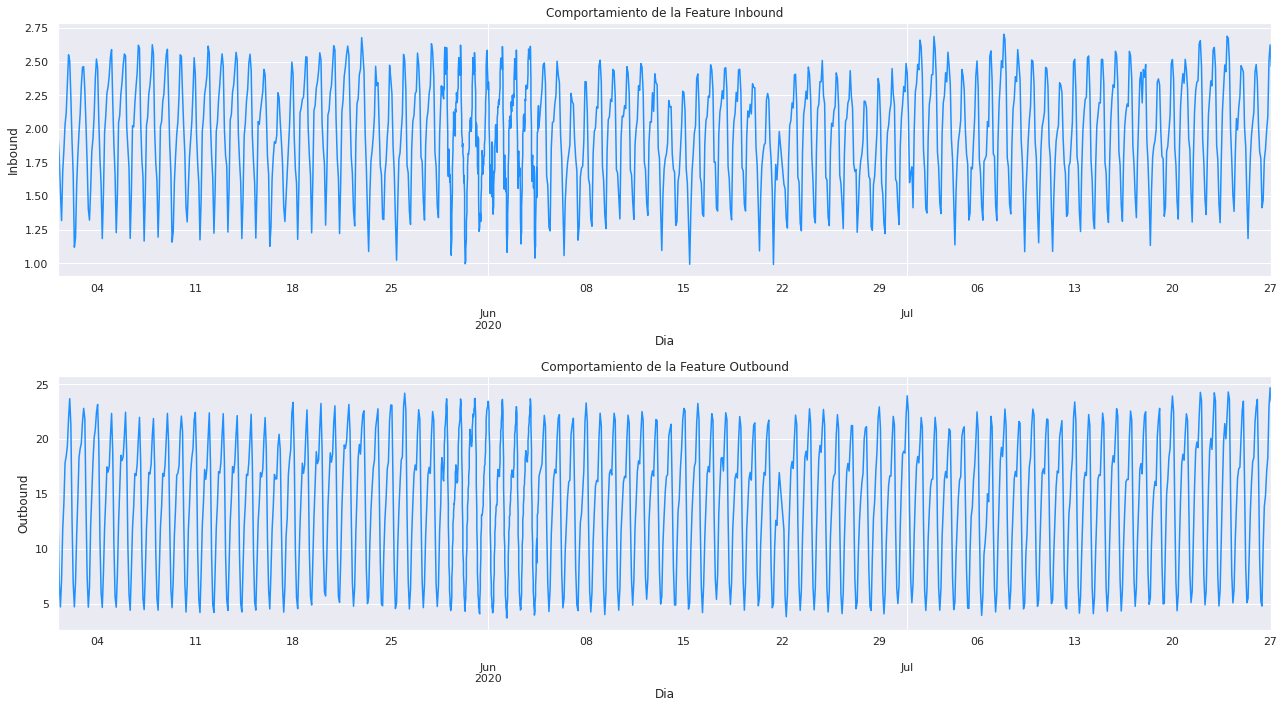

In [31]:
fig = plt.figure(figsize=(18, 10))

ax = plt.subplot(2, 1, 1)
y_in.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('Inbound')
ax.set_title('Comportamiento de la Feature Inbound')

ax = plt.subplot(2, 1, 2)
y_out.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('Outbound')
ax.set_title('Comportamiento de la Feature Outbound')

plt.tight_layout()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


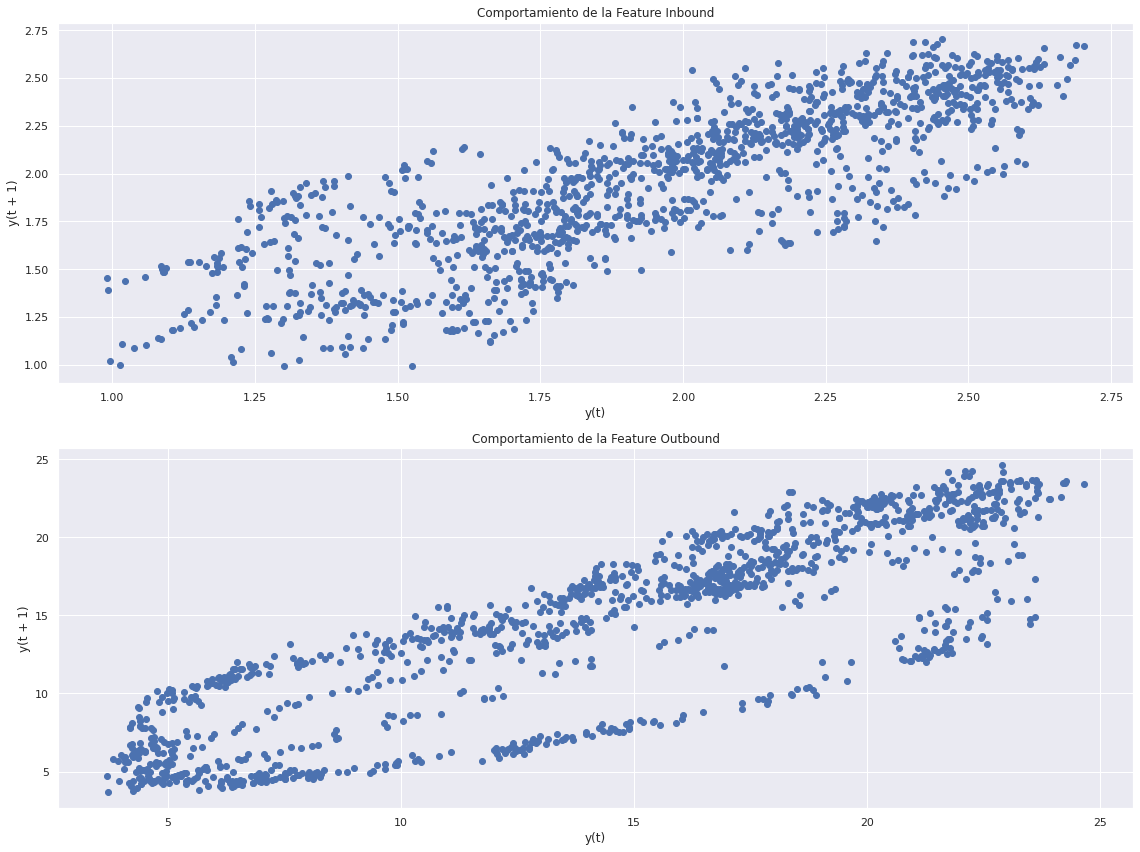

In [32]:
fig = plt.figure(figsize=(16, 12))

ax = plt.subplot(2, 1, 1)
lag_plot(df_tsf['INBOUND'], lag=1, ax=ax)
ax.set_title('Comportamiento de la Feature Inbound')

ax = plt.subplot(2, 1, 2)
lag_plot(df_tsf['OUTBOUND'], lag=1, ax=ax)
ax.set_title('Comportamiento de la Feature Outbound')

plt.tight_layout()
plt.show()

Podemos ver que existe cierta relacion entre la feature en el momento t y el momento t+1.

Tanto para `Inbound` y `Outbound`

A continuación mostramos algunas estadísticas del punto de medición seleccionado para la feature `Inbound` y `Outbound`

In [33]:
y_in.describe().round(3)

count    1291.000
mean        1.960
std         0.398
min         0.991
25%         1.681
50%         1.992
75%         2.285
max         2.704
Name: INBOUND, dtype: float64

In [34]:
y_out.describe().round(3)

count    1291.000
mean       14.323
std         5.963
min         3.692
25%         9.083
50%        15.414
75%        19.292
max        24.665
Name: OUTBOUND, dtype: float64

## **4. Aplicar diferentes Series de Tiempo**
---

### Series Temportales

Una serie temporal es un conjunto de observaciones que están ordenadas en el tiempo. Usualmente vienen acompañadas por una etiqueta de tiempo.

### Predicción (Forecast)

Nuestro objetivo es el de predecir el valor de una variable en instante futuro \\( {t + h} \\), dada una serie temporal con observaciones hasta el instante \\(t\\). 

Es decir queremos predecir \\(\hat{y}_{t + h}  \\) dado 
\\(y_1, y_2, ... , y_t \\)

\\(h\\) se suele llamar `horizon`



### 4.1 Random Walk (Naïve)

Usaremos el método Random Walk para ilustrar el proceso que seguiremos para generar forecast.
[Reference](https://medium.com/analytics-vidhya/time-series-forecasting-with-random-walk-58e84c93058b)

Se utiliza este metodo debido a que un pronóstico Naïve es óptimo cuando los datos siguen un patron `Random Walk`

Para la predicción (forecast) de un valor, se usa la última observación de la serie temporal:

$$
\hat{y}_{t + h} = y_{h}
$$

Pasos:
 1. Especificamos el **horizon (h)** para el forecast.
 2. Crear un rango de fechas o períodos a partir del índice de tiempo que 
 sigue a la última observación en los datos.
 3. Generar los **Forecasting** y almacénelos en una serie indexada por el 
 paso 2.

A continuación, generamos pronósticos puntuales para los datos de **AGOSTO** después usando los datos **JUNIO** Y **JULIO**.

#### 4.1.1 Creamos los dataset de train y test

Split Train and Test, para el dataset.

Se le asigna 312 muestras cada 2 horas de test

In [35]:
y_in_test = df_tsf.INBOUND.loc['2020-07-01 05:00:00':]
y_in_train = df_tsf[~df_tsf.INBOUND.isin(y_in_test)].INBOUND

y_out_test = df_tsf.OUTBOUND.loc['2020-07-01 05:00:00':]
y_out_train = df_tsf[~df_tsf.OUTBOUND.isin(y_out_test)].OUTBOUND

#### 4.1.2 Especificamos el **horizon (h)** para el forecast.

En donde h = len(y_test)

In [36]:
h = len(y_in_test)
h

311

In [37]:
y_in_train

FECHA_HORA_IDX
2020-05-01 03:00    1.950957
2020-05-01 05:00    1.793920
2020-05-01 07:00    1.533954
2020-05-01 09:00    1.317637
2020-05-01 11:00    1.682267
                      ...   
2020-06-30 19:00    2.275712
2020-06-30 21:00    2.486599
2020-06-30 23:00    2.414286
2020-07-01 01:00    2.112126
2020-07-01 03:00    1.599548
Freq: 2H, Name: INBOUND, Length: 980, dtype: float64

In [38]:
y_in_test

FECHA_HORA_IDX
2020-07-01 05:00    1.671233
2020-07-01 07:00    1.717076
2020-07-01 09:00    1.412610
2020-07-01 11:00    1.987084
2020-07-01 13:00    2.274948
                      ...   
2020-07-26 17:00    1.988802
2020-07-26 19:00    2.090933
2020-07-26 21:00    2.509492
2020-07-26 23:00    2.623932
2020-07-27 01:00    2.462458
Freq: 2H, Name: INBOUND, Length: 311, dtype: float64

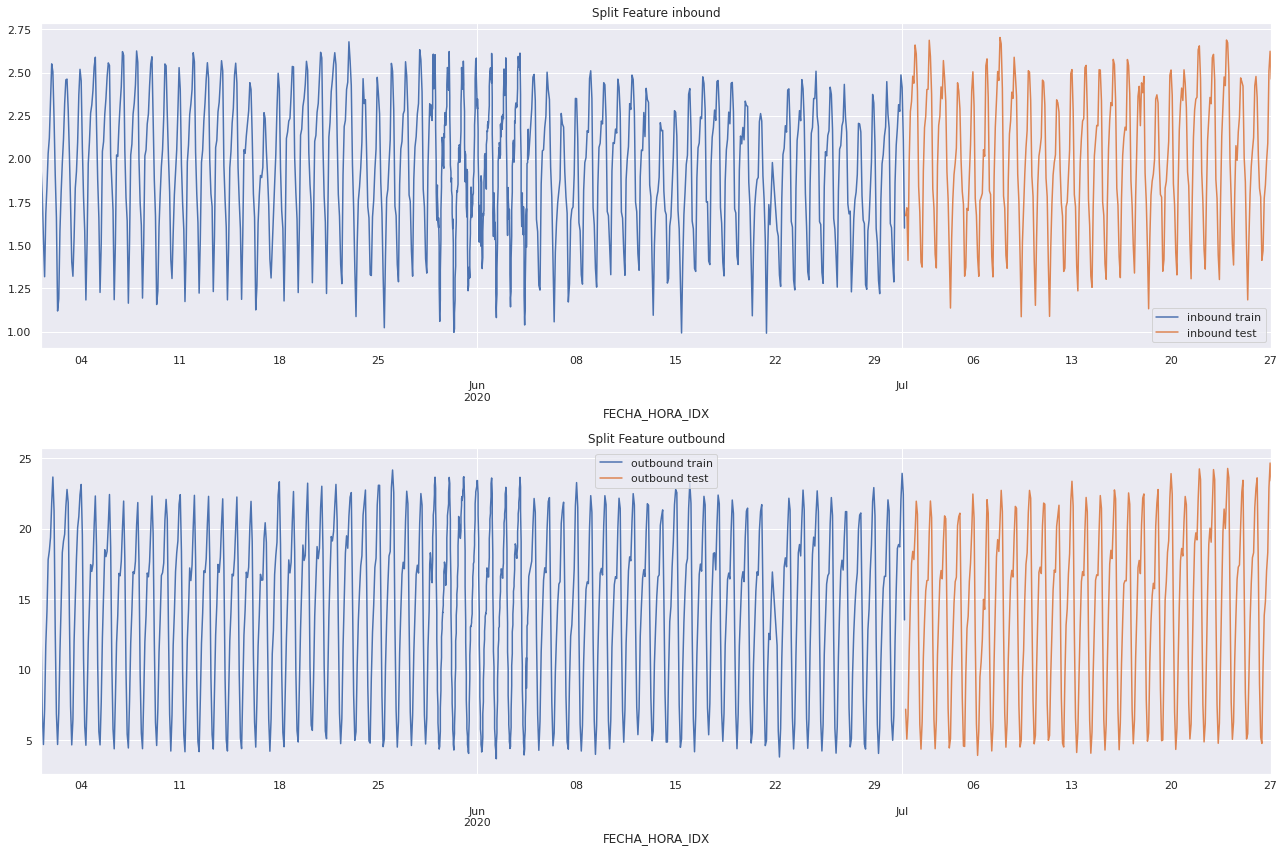

In [39]:
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(2, 1, 1)
y_in_train.plot(ax=ax, label='inbound train')
y_in_test.plot(ax=ax, label='inbound test')
ax.set_title('Split Feature inbound')
ax.legend()

ax = plt.subplot(2, 1, 2)
y_out_train.plot(ax=ax, label='outbound train')
y_out_test.plot(ax=ax, label='outbound test')
ax.set_title('Split Feature outbound')
ax.legend()

plt.tight_layout()
plt.show()

#### 4.1.3 Generamos las predicciones

Generamos las predicciones y las guardamos en el rango de periodos creado anteriormente.

In [40]:
forecast_in = pd.Series(
    np.repeat(y_in_train.iloc[-1], len(y_in_test)), index=y_in_test.index) 

forecast_out = pd.Series(
    np.repeat(y_out_train.iloc[-1], len(y_out_test)), index=y_out_test.index) 

In [41]:
forecast_in

FECHA_HORA_IDX
2020-07-01 05:00    1.599548
2020-07-01 07:00    1.599548
2020-07-01 09:00    1.599548
2020-07-01 11:00    1.599548
2020-07-01 13:00    1.599548
                      ...   
2020-07-26 17:00    1.599548
2020-07-26 19:00    1.599548
2020-07-26 21:00    1.599548
2020-07-26 23:00    1.599548
2020-07-27 01:00    1.599548
Freq: 2H, Length: 311, dtype: float64

In [42]:
forecast_out

FECHA_HORA_IDX
2020-07-01 05:00    13.538074
2020-07-01 07:00    13.538074
2020-07-01 09:00    13.538074
2020-07-01 11:00    13.538074
2020-07-01 13:00    13.538074
                      ...    
2020-07-26 17:00    13.538074
2020-07-26 19:00    13.538074
2020-07-26 21:00    13.538074
2020-07-26 23:00    13.538074
2020-07-27 01:00    13.538074
Freq: 2H, Length: 311, dtype: float64

el `forecast` para  Random Walk repite h veces el ultimo valor observado.

#### 3.1.2.5 Model diagnostics

 1. Residual plot.
 2. Residual ACF.
 3. Residual distribution plots.

Análisis de Residuos:

Los valores residuos corresponden a la diferencia entre los 
valores observados y los valores predichos. Estos residuos se calculan en el **training set** y se basan en predicciones de un paso

$$
e_{t} = y_{t} - \hat{y}_{t}
$$



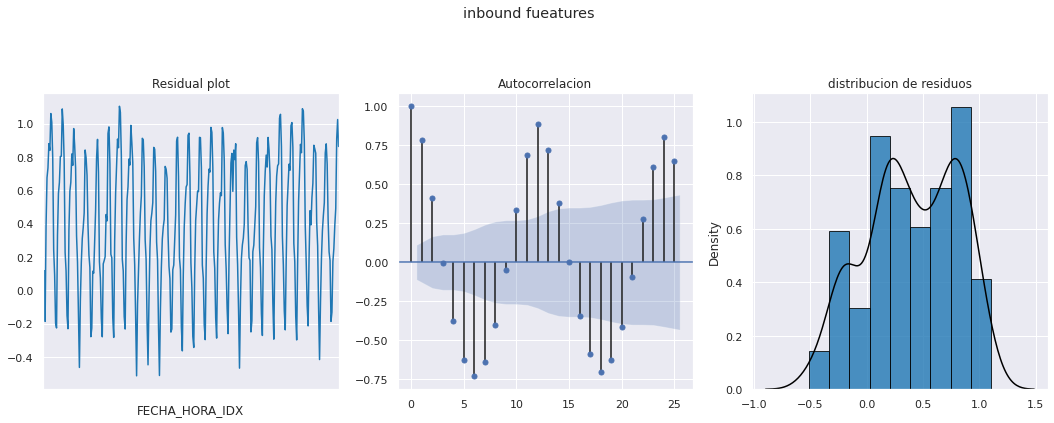

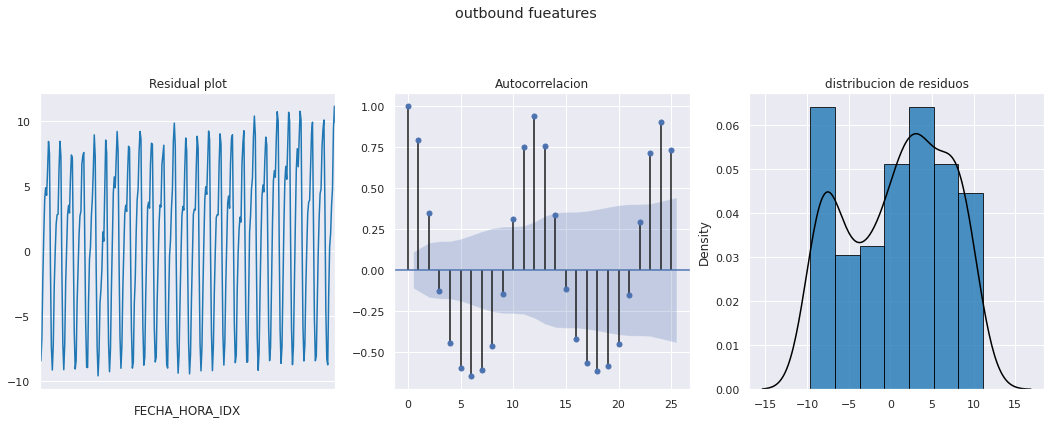

In [43]:
blue='#1F77B4'
values = {'inbound': forecast_in, 'outbound': forecast_out}
tests = {'inbound': y_in_test, 'outbound': y_out_test}

for pred in ['inbound', 'outbound']:
  resid = tests[pred] - values[pred]
  # ------- Residual plot ----------
  fig = plt.figure(figsize=(18, 12))
  fig.suptitle(f'{pred} fueatures')

  ax = plt.subplot(2, 3, 1)
  resid.plot(color=blue, ax=ax)
  ax.set_xticks([], minor=True) 
  ax.set_title(f'Residual plot')
  # ------ Autocorrelation ---------
  ax = plt.subplot(2, 3, 2)
  sm.graphics.tsa.plot_acf(resid, ax=ax) # lags=40
  ax.set_title(f'Autocorrelacion')
  # ------ dist Plot --------------
  ax = plt.subplot(2, 3, 3)
  sns.distplot(resid, ax=ax, 
             hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
             kde_kws={'color': 'black', 'alpha': 0.7})
  ax.set_title(f'distribucion de residuos')
  # end for
    
plt.show()

**Gráfico de residuos**

la presencia de patrones en el time plot de los `residuos` 
(como serie temporal) sugieren una predicción deficiente. 

\\(e_t\\) debe tener `media` 0 y valores `no` correlacionados

**Gráfico de autocorrelación para residuos**

Como el modelo no es bueno, las autocorrelaciones no son pequeñas,
ni similares a ruido

**Gráfico de distribucion para residuos**

No refleja que este sea un modelo ya la distribucion no residuos no tiene
una distribucion normal.

Esto se refleja tanto para `ìnbound` y `outbound`

#### 3.1.2.6 Model validation

Los errores se calculan en el test y la predicciones pueden incluir 
multiples pasos.


$$
e_{t + h} = y_{t+h} - \hat{y}_{t + h |t}
$$
Donde el `training` set está dado por \\( (y_i)_{i<t}\\)

Mean Absolute Error (MAE): \\( mean(|e_t|)\\)

Root Mean Squared Error(RMSE): \\( \sqrt{mean(e^2_t)}\\)


`Inbound`




In [44]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_in_test, forecast_in), 
      (y_in_test - forecast_in).sem())], 
    columns=['RMSE','SE'])
table.round(3)

RMSE     SE
0  0.566  0.023

`Outbound`

In [45]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_out_test, forecast_out), 
      (y_out_test - forecast_out).sem())], 
    columns=['RMSE','SE'])
table.round(3)

RMSE     SE
0  6.101  0.343

Para calcular los intervalo de forecasts, primero estimamos la desviación estándar de los errores.

In [46]:
resid = y_in_test - forecast_in
resid = y_in_train - y_in_train.shift(1) # the shift lags the series by one period
sigma = resid.std()
print(f'Inbound: {round(sigma, 3)}')

resid = y_out_test - forecast_out
resid = y_out_train - y_out_train.shift(1) # the shift lags the series by one period
sigma = resid.std()
print(f'Outbound: {round(sigma, 3)}')

Inbound: 0.227
Outbound: 3.116


Graficar el comportamiento de la variable con las predicciones  

In [47]:
intv_in = pd.concat(
    [forecast_in - stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
     forecast_in + stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], 
     axis=1)

intv_out = pd.concat(
    [forecast_out - stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
     forecast_out + stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], 
     axis=1)

In [48]:
point_in_pred = (intv_in[0] + intv_in[1]) / 2
point_out_pred = (intv_out[0] + intv_out[1]) / 2

In [49]:
def fanchart(y, forecast, intv1, intv2, intv3):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)

    with sns.axes_style('ticks'):
        fig, ax= plt.subplots(figsize=(18, 6))
        y.plot(color='#D62728')
        extended.plot(color='black', alpha=0.4, label='Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:,0]), last.append(intv3.iloc[:,1]), facecolor='#FAB8A4', lw=0)
        ax.fill_between(extended.index, last.append(intv2.iloc[:,0]), last.append(intv2.iloc[:,1]), facecolor='#F58671', lw=0)
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]), facecolor='#F15749', lw=0)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    return fig, ax

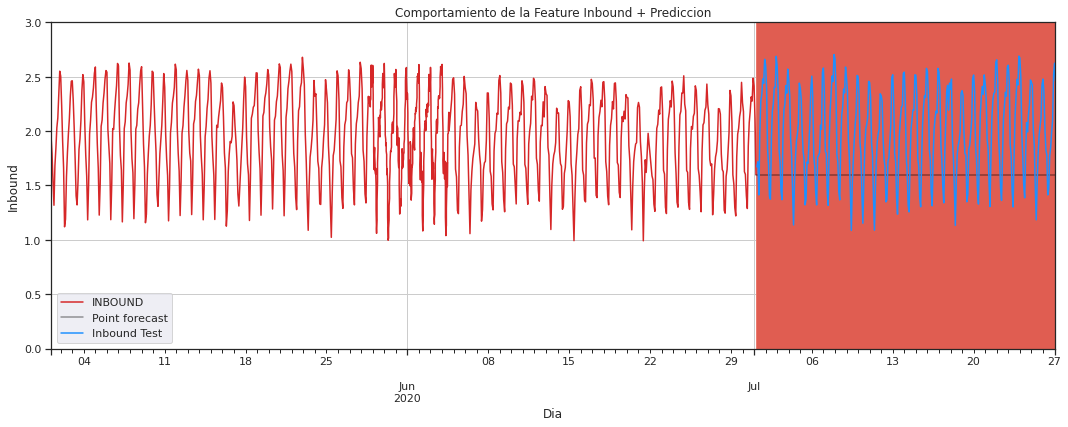

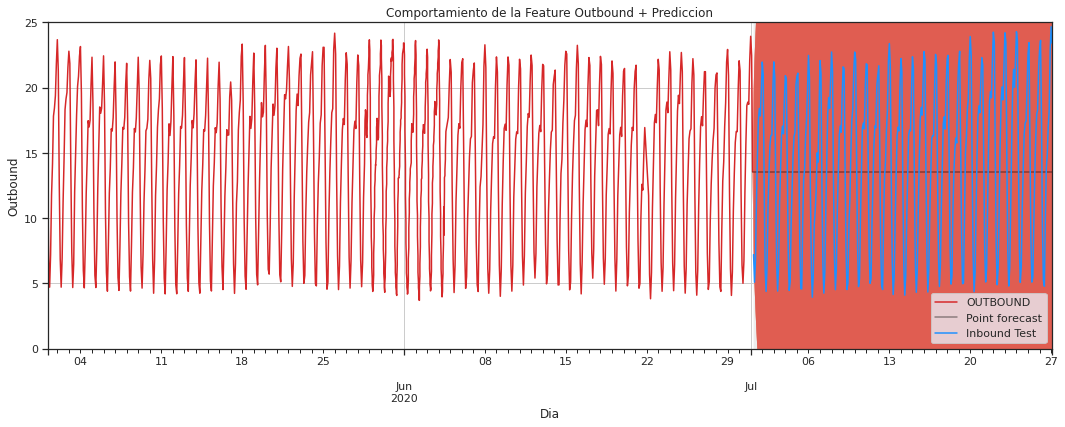

In [50]:
fig, ax1 = fanchart(y_in_train, point_in_pred, intv_in, intv_in, intv_in)
y_in_test.plot(color='dodgerblue', label='Inbound Test')
ax1.set_ylim(0, 3)
ax1.set_xlabel('Dia')
ax1.set_ylabel('Inbound')
ax1.set_title('Comportamiento de la Feature Inbound + Prediccion')
ax1.legend()

fig, ax2 = fanchart(y_out_train, point_out_pred, intv_out, intv_out, intv_out)
y_out_test.plot(color='dodgerblue', label='Inbound Test')
ax2.set_ylim(0, 25)
ax2.set_xlabel('Dia')
ax2.set_ylabel('Outbound')
ax2.set_title('Comportamiento de la Feature Outbound + Prediccion')
ax2.legend()


plt.show()

### **4.2 Seasonal Random Walk (Seasonal Naïve)**

https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

Si la serie presenta comportamientos estacionales, en lugar de usar la ultima observacion, usamos el ultimo valor correspondiente a la misma "estacion" actual:

$$
\hat{y}_{t + h} = y_{t + h - km}
$$

Donde:
* $m$ representa la longitud de la estacion
* $k$ es el "salto" a la estacion correspondiente:

$$
k = [{\frac{h - 1}{m + 1}}]
$$

Para saber si los datos son estacionales es necesario hacer una descompocision 
de la serie temporal. 


In [51]:
df_tsf

INBOUND   OUTBOUND
FECHA_HORA_IDX                       
2020-05-01 03:00  1.950957  12.810691
2020-05-01 05:00  1.793920   6.897302
2020-05-01 07:00  1.533954   4.698255
2020-05-01 09:00  1.317637   7.190201
2020-05-01 11:00  1.682267  11.765868
...                    ...        ...
2020-07-26 17:00  1.988802  17.029623
2020-07-26 19:00  2.090933  18.318292
2020-07-26 21:00  2.509492  22.904723
2020-07-26 23:00  2.623932  24.664950
2020-07-27 01:00  2.462458  23.395153

[1291 rows x 2 columns]

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


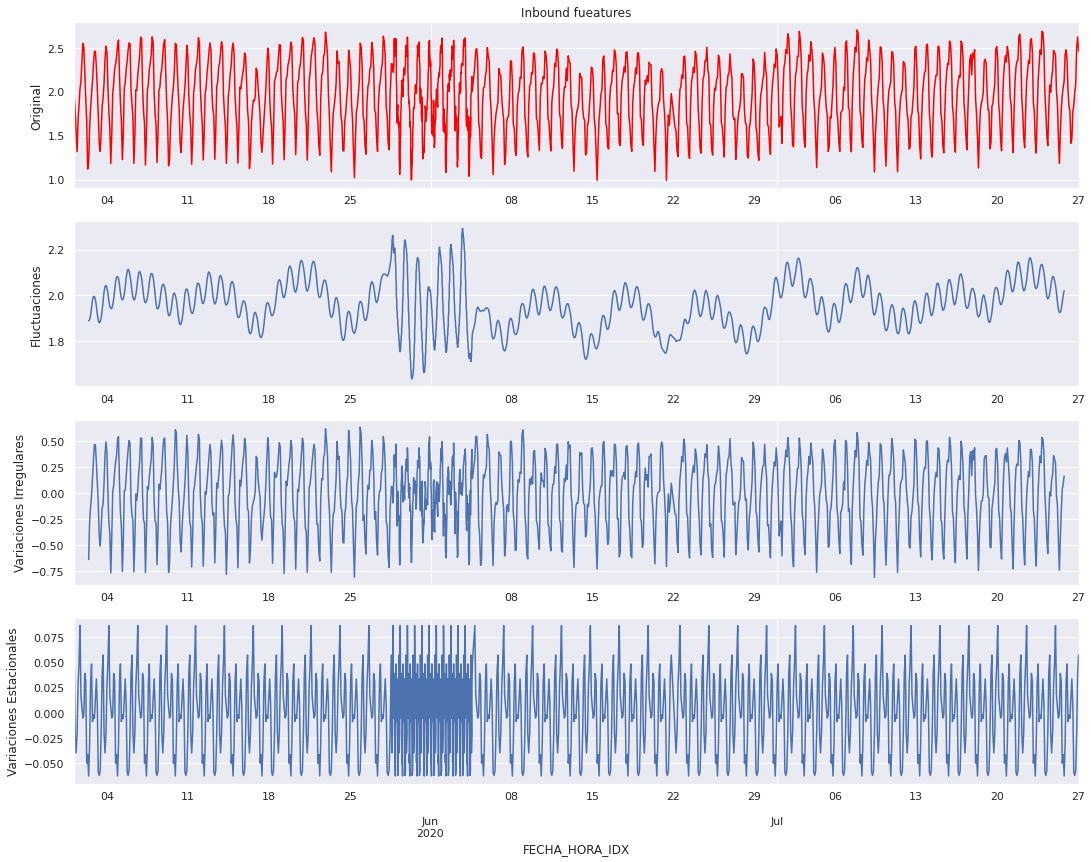

In [52]:
res = sm.tsa.seasonal_decompose(
    df_tsf['INBOUND'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
df_tsf.INBOUND.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.show()

Analisis para Outbound

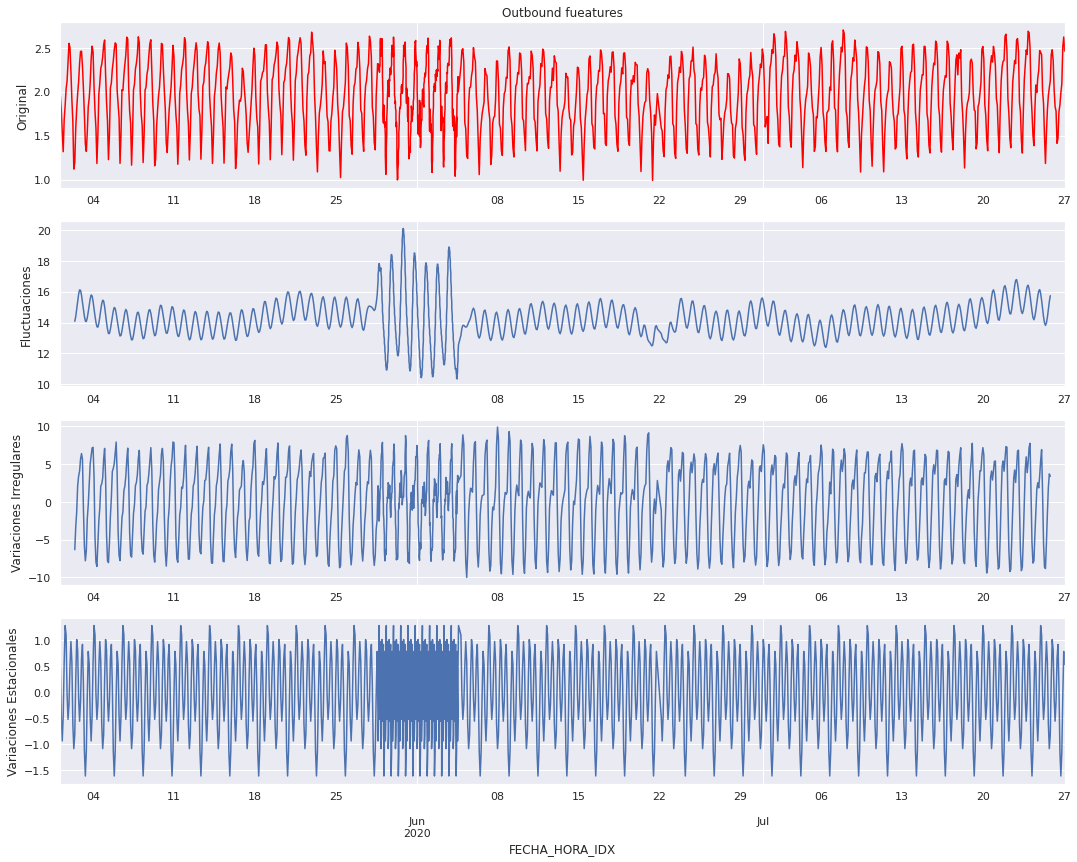

In [53]:
res = sm.tsa.seasonal_decompose(
    df_tsf['OUTBOUND'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Outbound fueatures')
df_tsf.INBOUND.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.show()

En base al analisis anterior se observa estacionalidad de los datos.

#### 4.2.1 Creamos los dataset de train y test

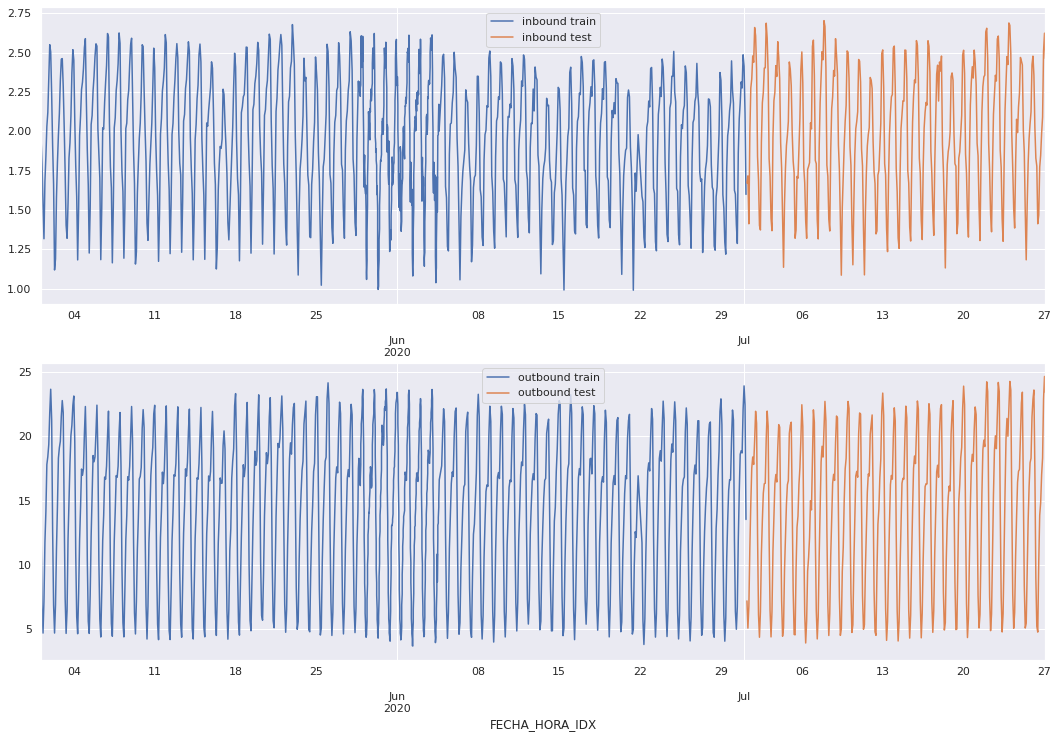

In [54]:
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(2, 1, 1)
y_in_train.plot(ax=ax, label='inbound train')
y_in_test.plot(ax=ax, label='inbound test')
ax.legend()

ax = plt.subplot(2, 1, 2)
y_out_train.plot(ax=ax, label='outbound train')
y_out_test.plot(ax=ax, label='outbound test')
ax.legend()

plt.show()

#### 4.2.2 Generamos las predicciones


Un modelo **seasonal random walk** es un caso especial de un modelo
 `ARIMA` en el que hay un orden de diferenciación estacional, un término constante y ningún otro parámetro
 
Es decir, un modelo "`ARIMA(0,0,0)x(0,1,0)` con constante ".
Usando la siguiente configuración: 

* Differencing: Nonseasonal Order = 0, Seasonal Order = 1
* AR, MA, SAR, SMA = 0
* Constant = ON

References:
- [[1]](https://faculty.fuqua.duke.edu/~rnau/Decision411_2007/411searw.htm) Seasonal random walk model
- [[2]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) statsmodels API


In [55]:
# ------- inbound --------
model_in = ARIMA(
    endog=y_in_train, exog=None, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12)
    ).fit()
    
# ------- Outbound --------
model_out = ARIMA(
    endog=y_out_train, exog=None, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12)
    ).fit()

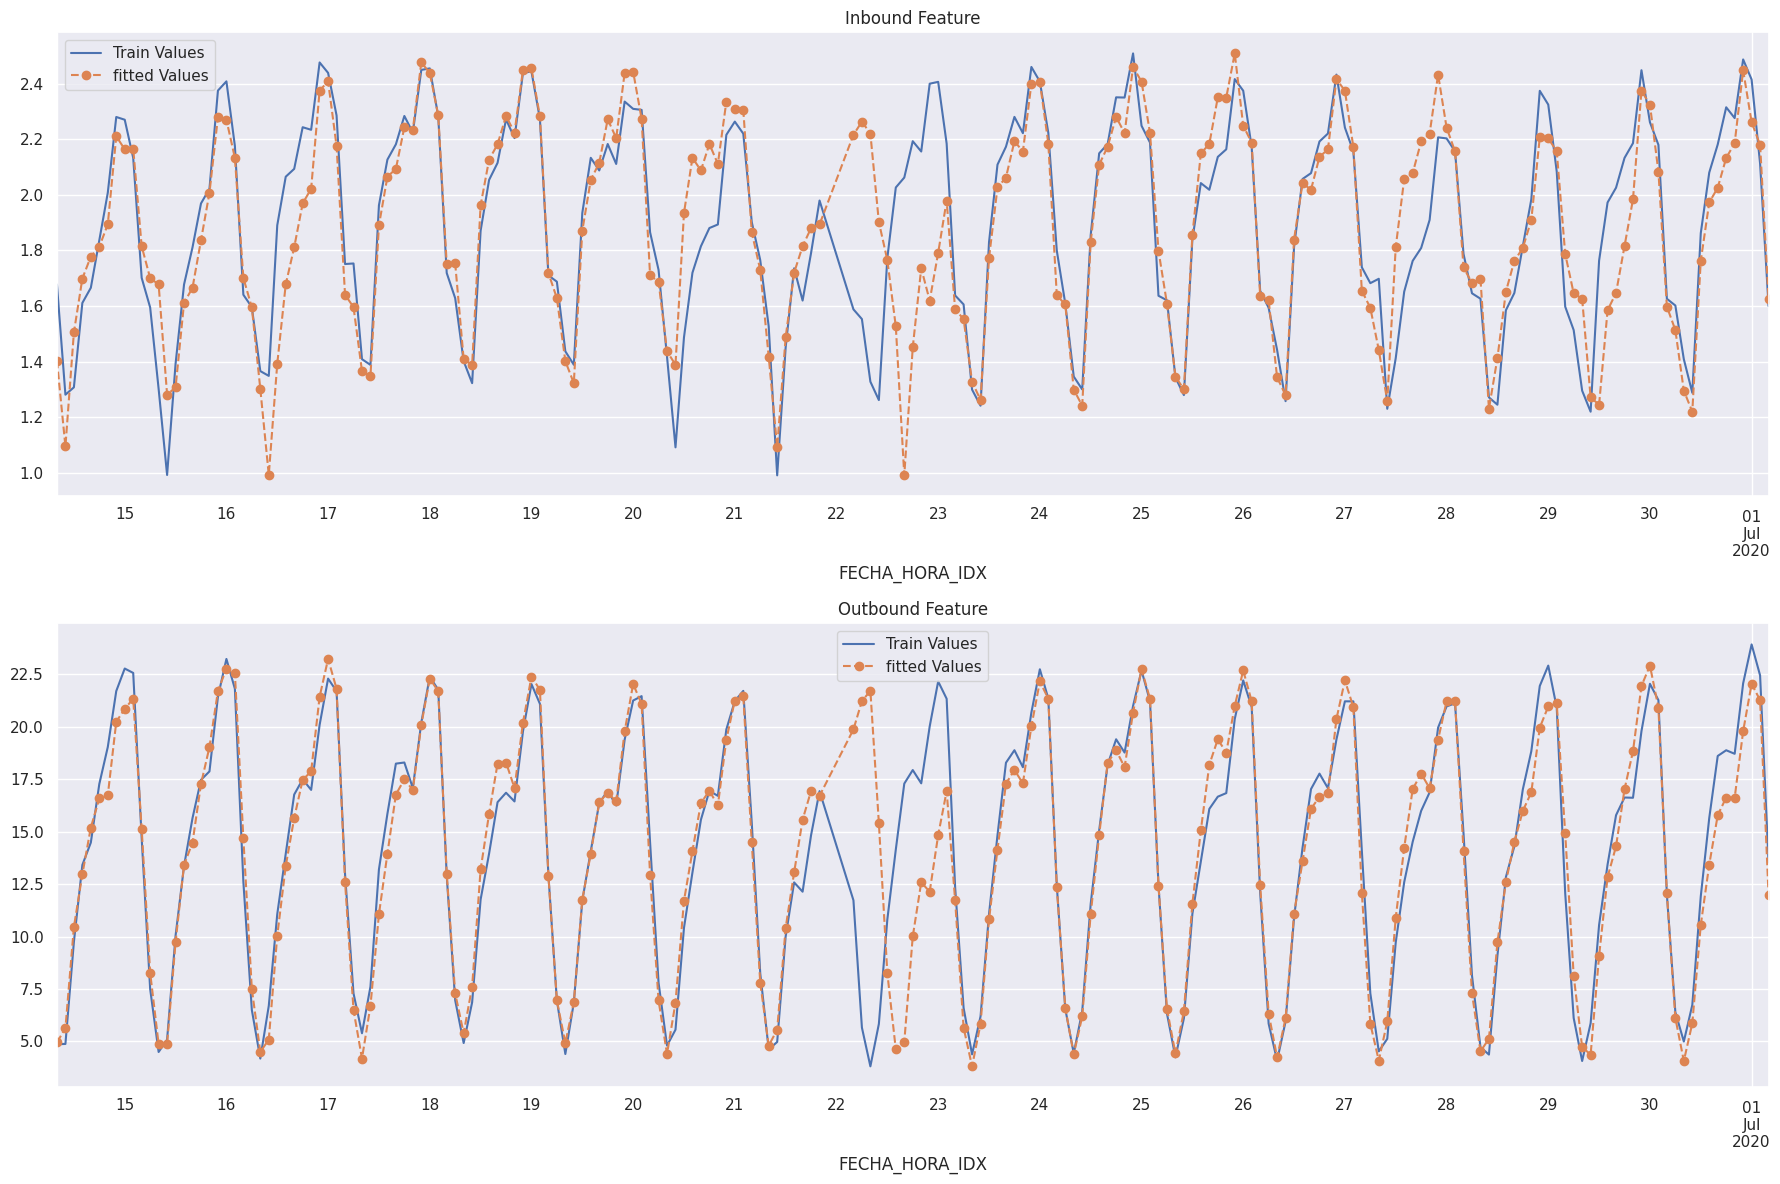

In [56]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_in_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model_in.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('Inbound Feature')
ax.legend()

ax = plt.subplot(2, 1, 2)
y_out_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model_out.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')

ax.set_title('Outbound Feature')
ax.legend()

plt.tight_layout()
plt.show()

#### 4.2.3 Model diagnostics

 1. Residual plot.
 2. Residual ACF.
 3. Residual distribution plots.




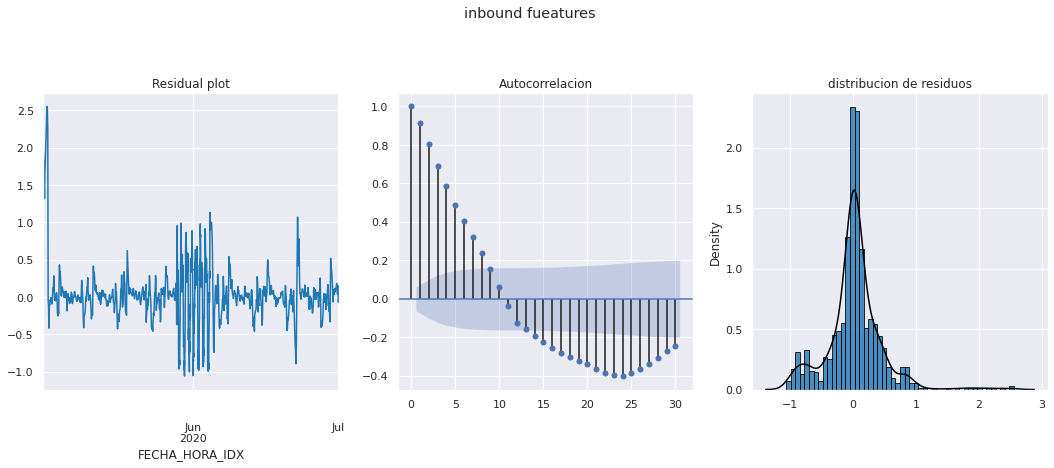

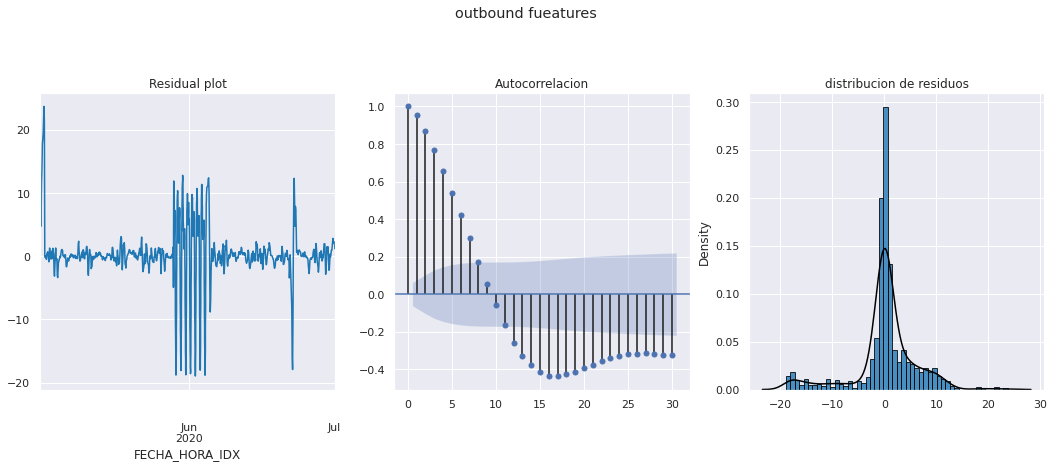

In [57]:
blue='#1F77B4'

fitteds = {'inbound': model_in.fittedvalues, 'outbound': model_out.fittedvalues}
trains = {'inbound': y_in_train, 'outbound': y_out_train}

for pred in ['inbound', 'outbound']:
  resid = trains[pred] - fitteds[pred]
  # ------- Residual plot ----------
  fig = plt.figure(figsize=(18, 12))
  fig.suptitle(f'{pred} fueatures')

  ax = plt.subplot(2, 3, 1)
  resid.plot(color=blue, ax=ax)
  ax.set_xticks([], minor=True) 
  ax.set_title(f'Residual plot')
  # ------ Autocorrelation ---------
  ax = plt.subplot(2, 3, 2)
  sm.graphics.tsa.plot_acf(resid, ax=ax) # lags=40
  ax.set_title(f'Autocorrelacion')
  # ------ dist Plot --------------
  ax = plt.subplot(2, 3, 3)
  sns.distplot(resid, ax=ax, 
             hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
             kde_kws={'color': 'black', 'alpha': 0.7})
  ax.set_title(f'distribucion de residuos')
    
plt.show()

**Gráfico de residuos**

A diferencia de modelo Random Walk no Seasonal, este modelo
los residuos se encuentran mas acotados, aun asi 
\\(e_t\\) no tiene `media` 0 

**Gráfico de autocorrelación para residuos**

Tambien en este grafico se aprecia una mejora con respecto al modelo anterior,
 ya que la mayoria de las autocorrelaciones son pequeñas.

 Tanto para `inbound` como para `outbound`

#### 4.2.4 Model validations



In [58]:
# Forecast
# 95% conf se, conf
# ------------ inbound -----------
fc = model_in.forecast(steps=len(y_in_test), exog=y_in_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_in_test.index

# -------- Outbound ----------------
fc = model_out.forecast(steps=len(y_out_test), exog=y_out_test, alpha=0.05) 
#Make as pandas series
fc_out = fc.reset_index(drop=True)
fc_out.index = y_out_test.index

Plot Forecast

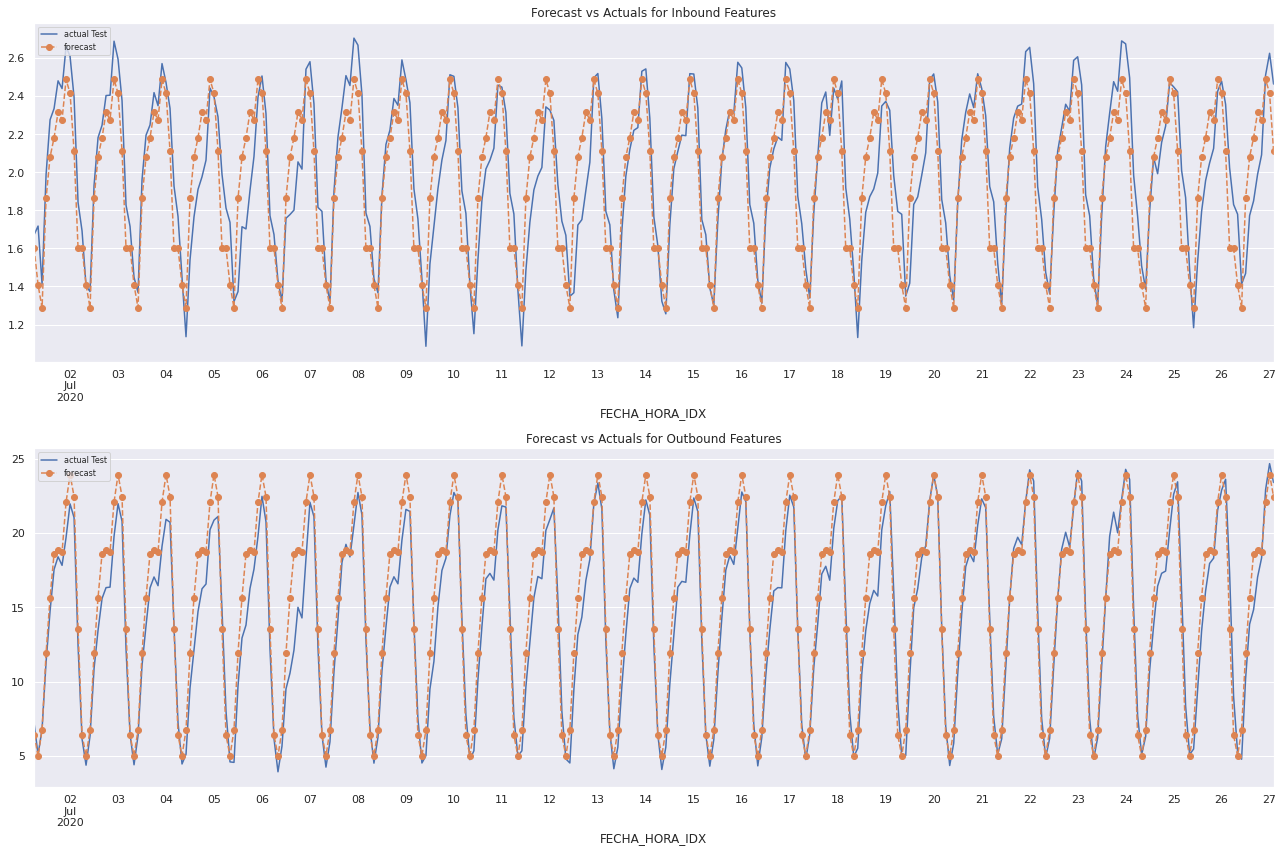

In [59]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_in_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

ax = plt.subplot(2, 1, 2)
y_out_test.plot(ax=ax, label='actual Test')
fc_out.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Outbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

Root mean square deviation 

Etonces se puede ver que error es mas bajo que para el modelo anterior

El modelo Seasonal Random Walk tiene buenos resutados debido a la 
estacionalidad de los mismos tanto para `inbound` como para `outbound`

In [60]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_in_test, fc_in), 
      (y_in_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

RMSE     SE
0   0.2  0.011

In [61]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_out_test, fc_out), 
      (y_out_test - fc_out).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

RMSE    SE
0  1.727  0.08

### 4.3 Exponential Smoothing

* https://en.wikipedia.org/wiki/Exponential_smoothing
* https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.



#### 4.3.1 Evaluamos *y* con el modelo exponencial

Primero:
Evaluamos *y* con el modelo exponencial para `inbound`

In [62]:
model_in_ses = SimpleExpSmoothing(
    y_in_train, initialization_method='legacy-heuristic'
    ).fit(smoothing_level=1, optimized=False)
model_in_ses.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                INBOUND   No. Observations:                  980
Model:             SimpleExpSmoothing   SSE                             50.456
Optimized:                      False   AIC                          -2903.125
Trend:                           None   BIC                          -2893.350
Seasonal:                        None   AICC                         -2903.084
Seasonal Periods:                None   Date:                 Sat, 03 Oct 2020
Box-Cox:                        False   Time:                         17:17:56
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                False
initial_level              1.9509568                  l.0                False
------------------------------------------------------------------------------
"""

`outbound`


In [63]:
model_out_ses = SimpleExpSmoothing(
    y_out_train, initialization_method='legacy-heuristic'
    ).fit(smoothing_level=1, optimized=False)
model_out_ses.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:               OUTBOUND   No. Observations:                  980
Model:             SimpleExpSmoothing   SSE                           9497.603
Optimized:                      False   AIC                           2229.817
Trend:                           None   BIC                           2239.592
Seasonal:                        None   AICC                          2229.858
Seasonal Periods:                None   Date:                 Sat, 03 Oct 2020
Box-Cox:                        False   Time:                         17:17:56
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                False
initial_level              12.810691                  l.0                False
------------------------------------------------------------------------------
"""

También AIC y BIC miran hacia fuera, así que continuamos nuestro análisis con MSE.

In [64]:
mse_in_ses = sm.tools.eval_measures.mse(y_in_train,  model_in_ses.fittedvalues)
print('Inbound - In-sample fit:')
print(' MSE {0:.3f}'.format(mse_in_ses))

mse_out_ses = sm.tools.eval_measures.mse(y_out_train,  model_out_ses.fittedvalues)
print('Outbound - In-sample fit:')
print(' MSE {0:.3f}'.format(mse_out_ses))

Inbound - In-sample fit:
 MSE 0.051
Outbound - In-sample fit:
 MSE 9.691


You can calculate AIC and BIC as follows

In [65]:
N = len(y_in_train)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_in_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3

print('----- Inbound -----')
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_out_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3

print('----- Outbound -----')
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


----- Inbound -----
 Log-likelihood    63.003
 AIC               -120.006
 BIC               -105.343
----- Outbound -----
 Log-likelihood    -2503.468
 AIC               5012.937
 BIC               5027.599


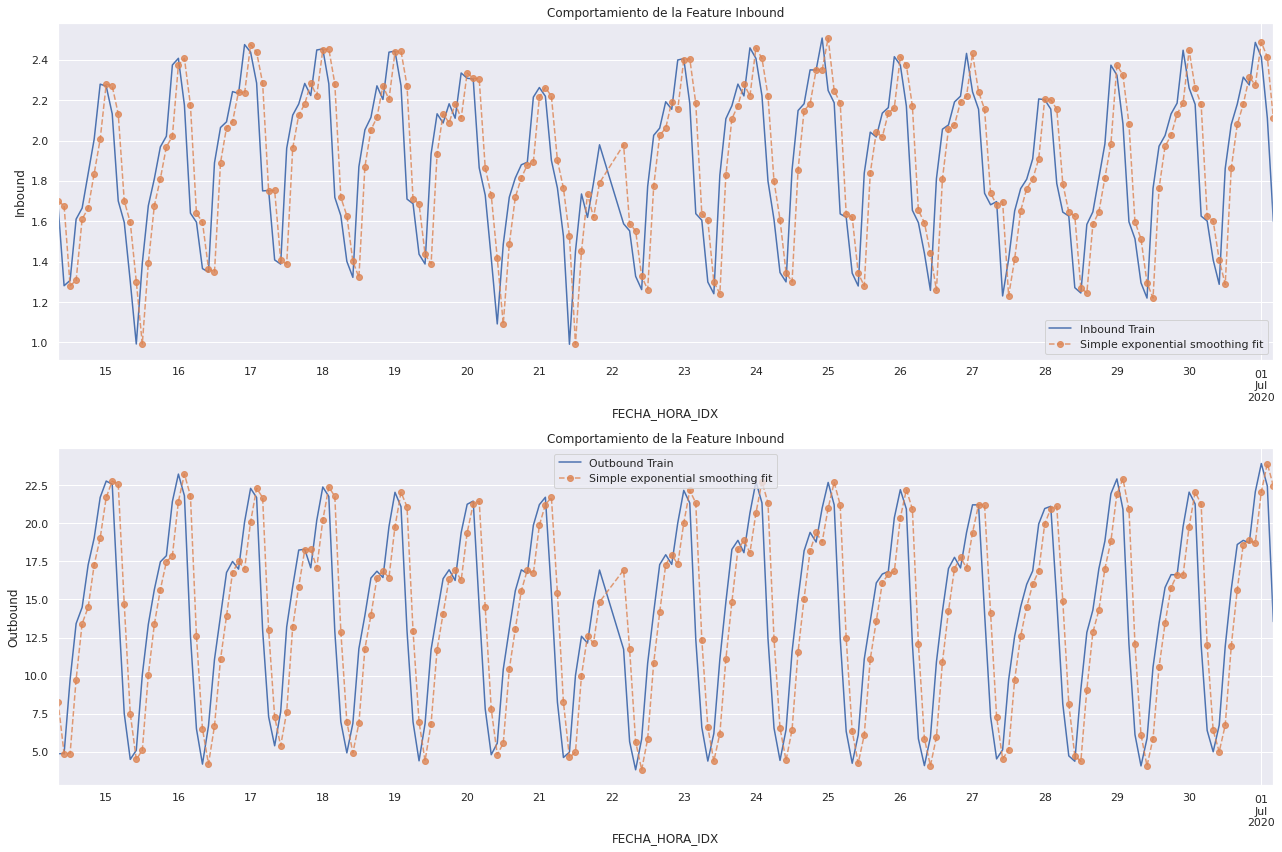

In [66]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_in_train.tail(200).plot(label='Inbound Train')

model_in_ses.fittedvalues.tail(200).plot(
     label='Simple exponential smoothing fit', 
     alpha=0.8, marker='o', linestyle='--')

ax.set_ylabel('Inbound')
ax.set_title('Comportamiento de la Feature Inbound')
plt.legend(loc='best')

ax = plt.subplot(2, 1, 2)
y_out_train.tail(200).plot(label='Outbound Train')
model_out_ses.fittedvalues.tail(200).plot(
     label='Simple exponential smoothing fit', 
     alpha=0.8, marker='o', linestyle='--')

ax.set_ylabel('Outbound')
ax.set_title('Comportamiento de la Feature Inbound')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#### 4.3.2 Model Diagnostic

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

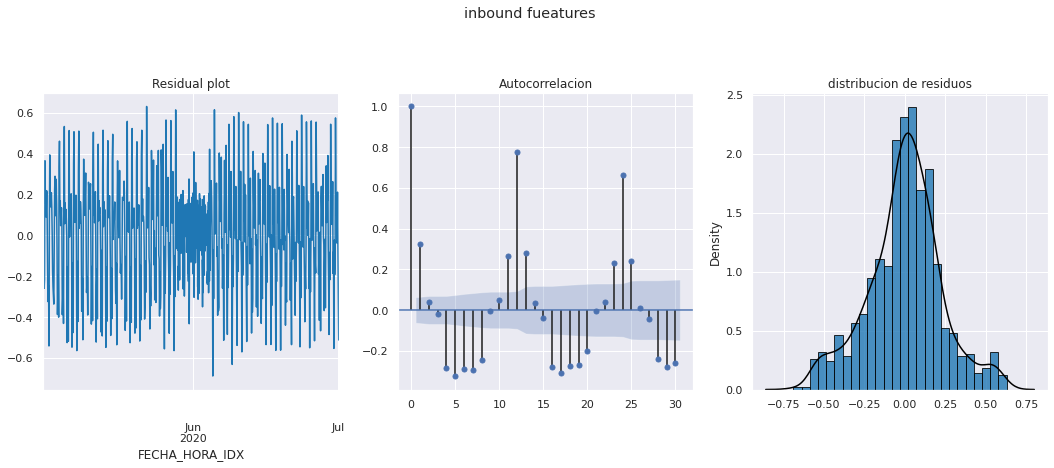

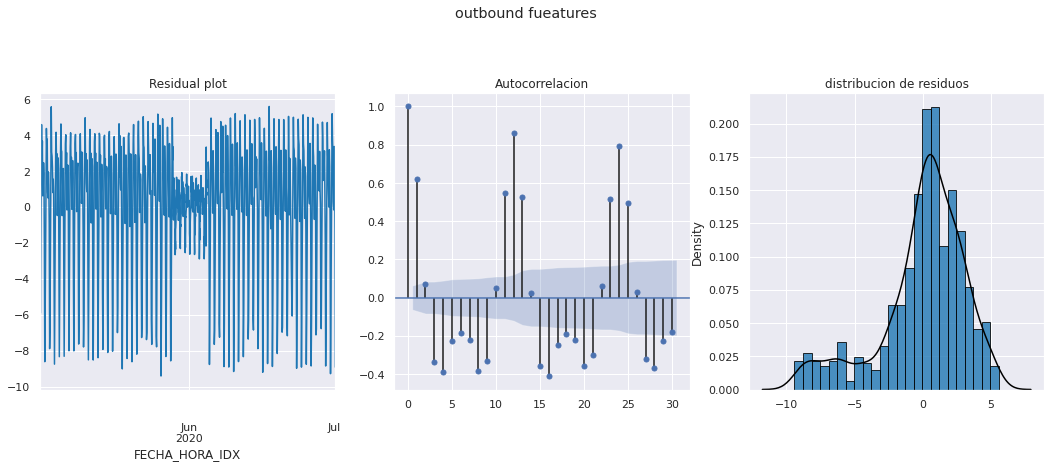

In [67]:
blue='#1F77B4'

fitteds = {'inbound': model_in_ses.fittedvalues,
           'outbound': model_out_ses.fittedvalues}
trains = {'inbound': y_in_train, 'outbound': y_out_train}

for pred in ['inbound', 'outbound']:
  resid = trains[pred] - fitteds[pred]
  # ------- Residual plot ----------
  fig = plt.figure(figsize=(18, 12))
  fig.suptitle(f'{pred} fueatures')

  ax = plt.subplot(2, 3, 1)
  resid.plot(color=blue, ax=ax)
  ax.set_xticks([], minor=True) 
  ax.set_title(f'Residual plot')
  # ------ Autocorrelation ---------
  ax = plt.subplot(2, 3, 2)
  sm.graphics.tsa.plot_acf(resid, ax=ax) # lags=40
  ax.set_title(f'Autocorrelacion')
  # ------ dist Plot --------------
  ax = plt.subplot(2, 3, 3)
  sns.distplot(resid, ax=ax, 
             hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
             kde_kws={'color': 'black', 'alpha': 0.7})
  ax.set_title(f'distribucion de residuos')
    
plt.show()

**Gráfico de residuos**

Podemos observar que las diferencias entre los valores reales y predichos siguen tambien un comportamiento estacionario, por lo cual nos indicaría que el modelo seleccionado es aplicable

**Gráfico de autocorrelación para residuos**

Podemos corroborar que los residuos tienen distribución normal por lo cual el modelo esta bien aplicado

Esto tanto para `inbound` como para `outbound`

#### 4.3.3 Model Validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [68]:
fc_in = model_in_ses.forecast(len(y_in_test))
fc_out = model_out_ses.forecast(len(y_out_test))

#### Forecast

We show how to do expanding and rolling point forecast. 

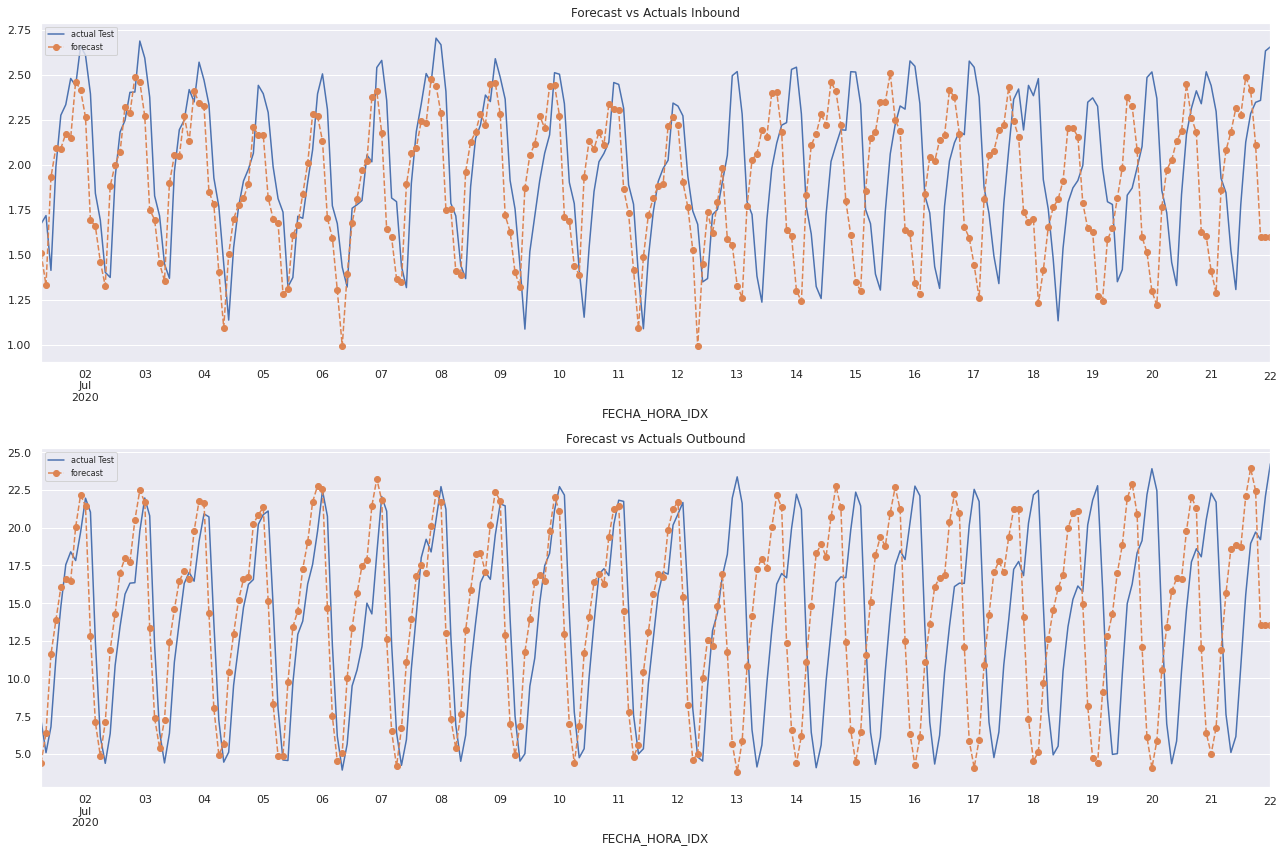

In [69]:
# Plot
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_in_test.head(250).plot(ax=ax, label='actual Test')
fc_in.head(250).plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals Inbound')
plt.legend(loc='upper left', fontsize=8)

ax = plt.subplot(2, 1, 2)
y_out_test.head(250).plot(ax=ax, label='actual Test')
fc_out.head(250).plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals Outbound')
plt.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [70]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_in_test.head(100), fc_in.head(100)), 
      (y_in_test.head() - fc_in.head(100)).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

RMSE     SE
0  0.309  0.156

In [71]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_out_test, fc_out), 
      (y_out_test - fc_out).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

RMSE     SE
0  7.375  0.419

Texto se puede apreciar que el error es mas bajo que el del primer modelo
teniendo en cuenta las primeras muestras.

## 5 Conclusiones
---

El Mejor modelo para el punto de medicion `NOC - 6720HI to EDC` 
tanto para la feature `inbound` como para `outbound` es:

El modelo:
 * Seasonal Random Walk 

 
 En especial porque las antes mencionadas tienen una componente estacionaria.